In [ ]:
# ولكن بان في الأوان الأخيره

In [3]:
! pip install pd

In [1]:
# open AR-all.alignment-FINAL.csv 
import pandas as pd

# open AR-all.alignment-FINAL.csv
df = pd.read_csv('ZAEBUC-v1.0/AR-all.alignment-FINAL.tsv', encoding='utf_8',sep='\t')
# get column 'raw'
raw = df['Raw']

In [2]:
def count_different_letters(word1, word2):
    count = 0
    length = min(len(word1), len(word2))
    maxi = max(len(word1), len(word2))
    count = maxi - length

    # Count the number of different letters
    count = count + sum(1 for c1, c2 in zip(word1[:length], word2[:length]) if c1 != c2)
    return count


In [3]:
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.disambig.mle import MLEDisambiguator

from camel_tools.utils.dediac import dediac_ar

mle = MLEDisambiguator.pretrained()


errors = []
for word in raw:
    # if word is string
    if isinstance(word, str):
        disambig = mle.disambiguate([str(word)])
        dediac_disambig = dediac_ar(disambig[0].analyses[0].analysis['diac'])
        if word == 'و':
            errors.append(2)
        elif word != dediac_disambig:
            # check how many letters are different
            errors.append(count_different_letters(word, dediac_disambig))
        else:
            errors.append(0)
    else:
        errors.append(0)

In [4]:
# add a column to the dataframe with the errors
df['errors'] = errors

# save the dataframe to a csv file
df.to_csv('AR-all.alignment-FINAL-with-errors.csv', encoding='utf_8',sep='\t')

In [ ]:
# 1479 waws

In [4]:
!pip install xmltodict

  Using cached xmltodict-0.13.0-py2.py3-none-any.whl (10.0 kB)


In [14]:
import xmltodict
import numpy as np
import pandas as pd
ZAEBUC_AR_COR = pd.read_csv('ZAEBUC-v1.0/AR-all.extracted.corrected.analyzed.corrected-FINAL.tsv', encoding='utf_8',sep='\t')

docs = ZAEBUC_AR_COR['Document'].apply(lambda x: x if x.startswith('<') else np.nan).dropna()

grades = []
word_count = []

for xml in docs:
    if xml != "</doc>":
        doc = xmltodict.parse(xml)
        grades.append(doc["doc"]["@CEFR"])
        word_count.append(doc["doc"]["@word_count"])

In [15]:
errors_df = pd.DataFrame()

errors_df['errors'] = df.groupby('Document')['errors'].sum()
errors_df['word count'] = df.groupby('Document')['Raw'].count()
errors_df['existing word count'] = word_count

# calculate the error rate
errors_df['error rate'] = errors_df['errors'] / errors_df['word count']
errors_df['grade'] = grades

errors_df.to_csv('error_rates.csv', index=True)


In [19]:
! pip install seaborn

  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)


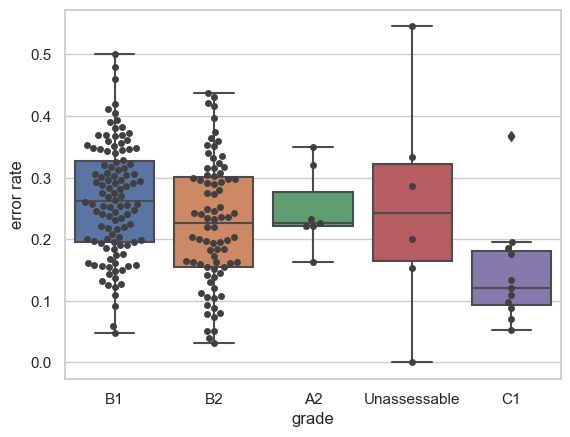

In [20]:
# plot the relation between the error rate and the grade
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

ax = sns.boxplot(x="grade", y="error rate", data=errors_df)
ax = sns.swarmplot(x="grade", y="error rate", data=errors_df, color=".25")

plt.show()